In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import optuna


In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')

In [3]:
train_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,140695,Vidya,Female,18.0,Ahmedabad,Working Professional,NaN,NaN,5.0,NaN,NaN,4.0,5-6 hours,Unhealthy,Class 12,No,2.0,4.0,Yes,1
140696,140696,Lata,Female,41.0,Hyderabad,Working Professional,Content Writer,NaN,5.0,NaN,NaN,4.0,7-8 hours,Moderate,B.Tech,Yes,6.0,5.0,Yes,0
140697,140697,Aanchal,Female,24.0,Kolkata,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,1.0,More than 8 hours,Moderate,B.Com,No,4.0,4.0,No,0
140698,140698,Prachi,Female,49.0,Srinagar,Working Professional,Plumber,NaN,5.0,NaN,NaN,2.0,5-6 hours,Moderate,ME,Yes,10.0,1.0,No,0


In [4]:
train_df.drop(['Name', 'id'], axis=1, inplace=True)
test_df.drop(['Name'], axis=1, inplace=True)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


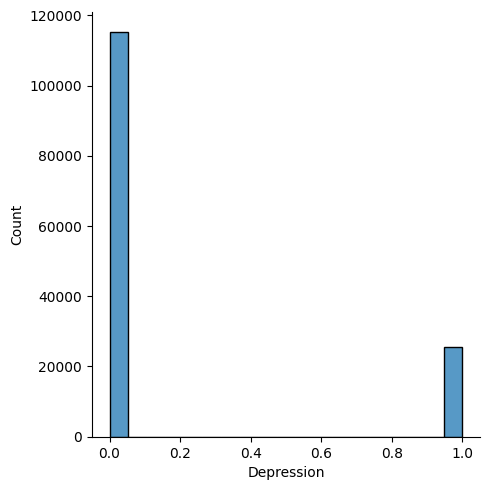

In [5]:
sns.displot(train_df['Depression'])

In [6]:
df_major = train_df[train_df['Age'].isin([49.0, 56.0, 38.0, 53.0])]
df_rest = train_df[~train_df['Age'].isin([49.0, 56.0, 38.0, 53.0])]

df_major_downsampled = (
    df_major.groupby('Age')
    .sample(n=4000, random_state=42)
)

train_df = pd.concat([df_major_downsampled, df_rest]).sample(frac=1, random_state=42)

In [7]:
train_df['Age'] = np.log1p(train_df['Age'])
test_df['Age'] = np.log1p(test_df['Age'])

In [8]:
df_major = train_df[train_df['Gender'].isin(['Male'])]
df_rest = train_df[~train_df['Gender'].isin(['Male'])]

df_major_downsampled = (
    df_major.groupby('Gender')
    .sample(n=67000, random_state=42)
)

train_df = pd.concat([df_major_downsampled, df_rest]).sample(frac=1, random_state=42)

In [9]:
nan_columns = train_df.columns[train_df.isna().any()].tolist()

cat_features = ['Gender', 'Working Professional or Student', 'Profession',
                'Sleep Duration', 'Dietary Habits', 'Degree','Have you ever had suicidal thoughts ?',
                'Family History of Mental Illness', 'City']

nan_cat_features = [x for x in nan_columns if x in cat_features]

train_df[nan_cat_features] = train_df[nan_cat_features].astype(str).fillna('nan')
test_df[nan_cat_features] = test_df[nan_cat_features].astype(str).fillna('nan')


In [10]:
y = train_df['Depression']
X = train_df.drop(['Depression'], axis=1)

test_ids = test_df['id']
test_data = test_df.drop(['id'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)



In [11]:
from catboost import CatBoostClassifier, Pool

model = CatBoostClassifier(
    iterations=1100,
    learning_rate=0.02,
    depth=8,
    loss_function='Logloss',
    eval_metric='Accuracy',
    cat_features=cat_features,
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

model.fit(X, y, cat_features=cat_features)

0:	learn: 0.9237141	total: 208ms	remaining: 3m 48s
100:	learn: 0.9352914	total: 14.2s	remaining: 2m 20s
200:	learn: 0.9382595	total: 27.5s	remaining: 2m 2s
300:	learn: 0.9395571	total: 40.4s	remaining: 1m 47s
400:	learn: 0.9405672	total: 52.5s	remaining: 1m 31s
500:	learn: 0.9412898	total: 1m 4s	remaining: 1m 17s
600:	learn: 0.9422455	total: 1m 16s	remaining: 1m 3s
700:	learn: 0.9429448	total: 1m 28s	remaining: 50.4s
800:	learn: 0.9436053	total: 1m 41s	remaining: 37.7s
900:	learn: 0.9442968	total: 1m 53s	remaining: 25s
1000:	learn: 0.9450738	total: 2m 5s	remaining: 12.4s
1099:	learn: 0.9457964	total: 2m 18s	remaining: 0us


In [12]:
preds = model.predict(X_valid)

accuracy = accuracy_score(y_valid, preds)

print(f"📉 Accuracy: {accuracy}")

📉 Accuracy: 0.9431235431235431


In [13]:
test_pool = Pool(
    data=test_data,
    cat_features=cat_features
)

test_preds = model.predict(test_pool)


submission = pd.DataFrame({'id': test_ids, 'Depression': test_preds})
submission.to_csv('submission.csv', index=False)